# ASEWA Project - VGG19
Using the weights of a pretrained VGG19 on our own VGG19 and performing Style Transfer
---
Janina Klarmann, Laura Kühl

## Setup

In [1]:
import tensorflow as tf
import numpy as np
from torchvision import transforms
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator
import math

import PIL.Image
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import time
import functools

import tqdm
import datetime

## Own VGG19 Model

In [18]:
# Creating a VGG19 Model
class Our_Own_VGG19_Model(tf.keras.Sequential):
  def __init__(self):
    super(Our_Own_VGG19_Model,self).__init__()
    self.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu', name='convlayer11', input_shape=(224,224,3)))
    self.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu', name='convlayer12'))
    self.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
    self.add(tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu', name='convlayer21'))
    self.add(tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu', name='convlayer22'))
    self.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    self.add(tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu', name='convlayer31'))
    self.add(tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu', name='convlayer32'))
    self.add(tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu', name='convlayer33'))
    self.add(tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu', name='convlayer34'))
    self.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    self.add(tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation='relu', name='convlayer41'))
    self.add(tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation='relu', name='convlayer42'))
    self.add(tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation='relu', name='convlayer43'))
    self.add(tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation='relu', name='convlayer44'))
    self.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    self.add(tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation='relu', name='convlayer51'))
    self.add(tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation='relu', name='convlayer52'))
    self.add(tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation='relu', name='convlayer53'))
    self.add(tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation='relu', name='convlayer54'))
    self.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    # self.add(tf.keras.layers.GlobalAveragePooling2D())
    self.add(tf.keras.layers.Flatten())
    self.add(tf.keras.layers.Dense(4096, activation=tf.nn.relu))
    self.add(tf.keras.layers.Dense(4096, activation=tf.nn.relu))
    self.add(tf.keras.layers.Dense(1000, activation=tf.nn.softmax))
    # self.build((None, None, None, 3))
    self.compile(optimizer= tf.keras.optimizers.Adam(0.003), loss='categorical_crossentropy', metrics=['accuracy'])

## Load Weights

In [ ]:
ourmodel = Our_Own_VGG19_Model()

In [ ]:
import requests
url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5"
r = requests.get(url, allow_redirects=True)
open('vgg19_weights_tf_dim_ordering_tf_kernels.h5', 'wb').write(r.content)

In [ ]:
# Loads the weights
ourmodel.load_weights("vgg19_weights_tf_dim_ordering_tf_kernels.h5")

## Layers

In [3]:
style_layers_our_own_vgg19 = ['convlayer11','convlayer21','convlayer31','convlayer41', 'convlayer51']
content_layer_our_own_vgg19 = ['convlayer54']

## Images

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


In [5]:
# Define a function to load an image and limit its maximum dimension to 512 pixels.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [12]:
content_image = load_img(content_path)
style_image = load_img(style_path)

## Style Transfer

### Models

In [19]:
import requests
def Create_Our_Own_VGG19_Model(layer_names):
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  #Load the weights
  url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5"
  r = requests.get(url, allow_redirects=True)
  open('vgg19_weights_tf_dim_ordering_tf_kernels.h5', 'wb').write(r.content)
  # Load our model
  ownvgg19 = Our_Own_VGG19_Model()
  ownvgg19.load_weights("vgg19_weights_tf_dim_ordering_tf_kernels.h5")
  # Get output layers corresponding to style and content layers 
  outputs = [ownvgg19.get_layer(name).output for name in layer_names]
  # Build model 
  model = tf.keras.Model([ownvgg19.input], outputs)

  return model 

In [20]:
class StyleExtractionModelOurOwnVgg19(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleExtractionModelOurOwnVgg19, self).__init__()
    self.ourownvgg19 = Create_Our_Own_VGG19_Model(style_layers+content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.ourownvgg19.trainable = False 

  def gram_matrix(self, input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    preprocessed_input = tf.image.resize(preprocessed_input, [224,224])
    outputs = self.ourownvgg19(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [self.gram_matrix(style_output)
                    for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [21]:
class StyleTrainingModelOurOwnVGG19(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleTrainingModelOurOwnVGG19, self).__init__()
    self.ExtractionModel = StyleExtractionModelOurOwnVgg19(style_layers, content_layers)
    self.opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    self.style_weight = 1e-2
    self.content_weight = 1e4
    self.style_targets = self.ExtractionModel(style_image)['style']
    self.content_targets = self.ExtractionModel(content_image)['content']
    self.num_style_layers = len(style_layers)
    self.num_content_layers = len(content_layers)

  def clip_0_1(self, image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

  def tensor_to_image(self, tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
 
  def style_content_loss(self, outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-self.style_targets[name])**2) 
                          for name in style_outputs.keys()])
    style_loss *= self.style_weight / self.num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.content_targets[name])**2) 
                            for name in content_outputs.keys()])
    content_loss *= self.content_weight / self.num_content_layers
    loss = style_loss + content_loss
    return loss

  @tf.function()
  def train_step(self, img):
    with tf.GradientTape() as tape:
      outputs = self.ExtractionModel(img)
      loss = self.style_content_loss(outputs)

    grad = tape.gradient(loss, img)
    self.opt.apply_gradients([(grad, img)])
    img.assign(self.clip_0_1(img))

### Image Trainingsteps

In [22]:
MyModelOurOwnVGG19 = StyleTrainingModelOurOwnVGG19(style_layers_our_own_vgg19, content_layer_our_own_vgg19)
image = tf.Variable(content_image)

In [ ]:
for i in range(100):
  print(f'Working on Trainingstep {i}...')
  MyModelOurOwnVGG19.train_step(image)

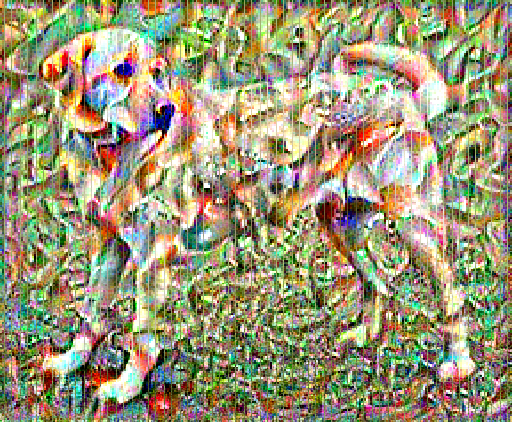

In [24]:
final_image = MyModelOurOwnVGG19.tensor_to_image(image)
final_image